In [1]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import os
import sys

import torch
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2
from einops import rearrange

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# local imports
root_dir = os.path.abspath(os.path.join('..', '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

from data_modules import urbansyn
from urbansyn_segformer import UrbanSynSegFormer

Data preparation

In [2]:
# Download the UrbanSyn dataset from the huggingface hub.
# It is 21 GB in size, so it might take several minutes
us = urbansyn.UrbanSynDownloader(os.path.join(root_dir, 'data'))
us.download()

# Downscale the original data by a factor of 2 and 4.
# This produces images of size 256x512 for fast training.
# Downscaling may also take a while.
for factor in [2, 4]:
    us.downscale(factor)

c:\main\repos\computer-vision\data\urbansyn already exists.
c:\main\repos\computer-vision\data\urbansyn_resized\512 already exists.
c:\main\repos\computer-vision\data\urbansyn_resized\256 already exists.


Taking a look at a train data example

torch.Size([16, 3, 512, 1024]) torch.Size([16, 512, 1024])


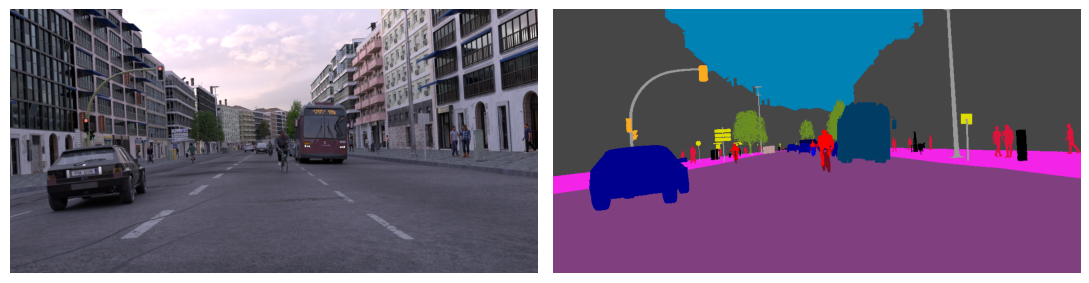

In [3]:
datamodule = us.get_datamodule(downscaling=2)
datamodule.setup('fit')
for x, y in datamodule.train_dataloader():
    print(x.size(), y.size())
    fig,ax = plt.subplots(1, 2, figsize=(11,3))
    ax[0].imshow(rearrange(urbansyn.INV_NORMALIZE(x[0]), 'c h w -> h w c'))
    ax[0].axis('off')
    ax[1].imshow(urbansyn.colorize_segmap(y, for_pil=True)[0])
    ax[1].axis('off')
    plt.tight_layout()
    # plt.savefig('../../img/urbansyn_example.png')
    plt.show()
    break

Finetuning a SegFormer pretrained on Cityscapes

In [4]:
DEBUG = False

LR = 1e-4
LR_GAMMA = 0.99
BATCH_SIZE = 16
IMAGE_DOWNSCALING = 4

LOAD_BEST_CHECKPOINT = False
LOAD_LAST_CHECKPOINT = False
load_version = f'D4_B16_LR0.0001_LRG0.99'

OVERRIDE_HP = False  # if you are loading a checkpoint but want to use the hyperparameters specified above

version_name = f'D{IMAGE_DOWNSCALING}_B{BATCH_SIZE}_LR{LR}_LRG{LR_GAMMA}'

if LOAD_BEST_CHECKPOINT:
    lightning_model = UrbanSynSegFormer.load_from_checkpoint('best.ckpt')
elif LOAD_LAST_CHECKPOINT:
    lightning_model = UrbanSynSegFormer.load_from_checkpoint(os.path.join('lightning_logs', load_version, 'last.ckpt'))
else:
    lightning_model = UrbanSynSegFormer(learning_rate=LR, lr_gamma=LR_GAMMA)

if OVERRIDE_HP:
    lightning_model.hparams['learning_rate'] = LR
    lightning_model.lr = LR 
    lightning_model.hparams['lr_gamma'] = LR_GAMMA
    lightning_model.lr_gamma = LR_GAMMA

print(lightning_model.hparams)

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join('lightning_logs', version_name),  # Where to save the checkpoints
    filename='{epoch}-{val_loss:.4f}',  # Filename format
    monitor='val_loss',  # Metric to monitor
    save_last=True,  # Always save the last checkpoint
)

logger = TensorBoardLogger('.', version=version_name)

trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=200),
                             LearningRateMonitor(logging_interval='epoch'),
                             checkpoint_callback],
                  fast_dev_run=DEBUG,
                  max_epochs=500,
                  precision='bf16-mixed',
                  logger=logger,
                 )

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


"learning_rate": 0.0001
"lr_gamma":      0.99


In [5]:
datamodule = us.get_datamodule(batch_size=BATCH_SIZE, downscaling=IMAGE_DOWNSCALING)

In [6]:
trainer.fit(lightning_model, datamodule=datamodule)

c:\main\repos\computer-vision\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\main\repos\computer-vision\experiments\urbansyn_segformer\lightning_logs\D4_B16_LR0.0001_LRG0.99 exists and is not empty.

  | Name    | Type                             | Params | Mode 
---------------------------------------------------------------------
0 | model   | SegformerForSemanticSegmentation | 3.7 M  | eval 
1 | loss_fn | DiceLoss                         | 0      | train
2 | metrics | MeanIoU                          | 0      | train
---------------------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.876    Total estimated model params size (MB)
3         Modules in train mode
213       Modules in eval mode
c:\main\repos\computer-vision\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many w

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Loading trained model and evaluating it

In [6]:
# specify the desired checkpoint here:
checkpoint_path = 'best.ckpt'
lightning_model = UrbanSynSegFormer.load_from_checkpoint(checkpoint_path)
datamodule = us.get_datamodule(batch_size=16, downscaling=2)
trainer = Trainer()
validation = trainer.validate(lightning_model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\main\repos\computer-vision\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        _MeanIoU_           0.6165197491645813
        accuracy            0.9289354681968689
       bicycle_IoU          0.5134806632995605
      building_IoU          0.8803015947341919
         bus_IoU             0.685682475566864
         car_IoU            0.8642052412033081
        fence_IoU           0.5061076283454895
     motorcycle_IoU         0.40058043599128723
       person_IoU           0.6775013208389282
        pole_IoU            0.4687785506248474
        rider_IoU           0.33594080805778503
        road_IoU            0.9596452713012695
      sidewalk_IoU          0.7806146740913391
         sky_IoU            0.8403222560882568
       terrain_IoU          0.3681371510028839
    tra

Showing results for a small validation batch and a demo image

In [7]:
# specify the desired checkpoint here:
checkpoint_path = 'best.ckpt'
lightning_model = UrbanSynSegFormer.load_from_checkpoint(checkpoint_path)
trainer = Trainer(limit_predict_batches=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.


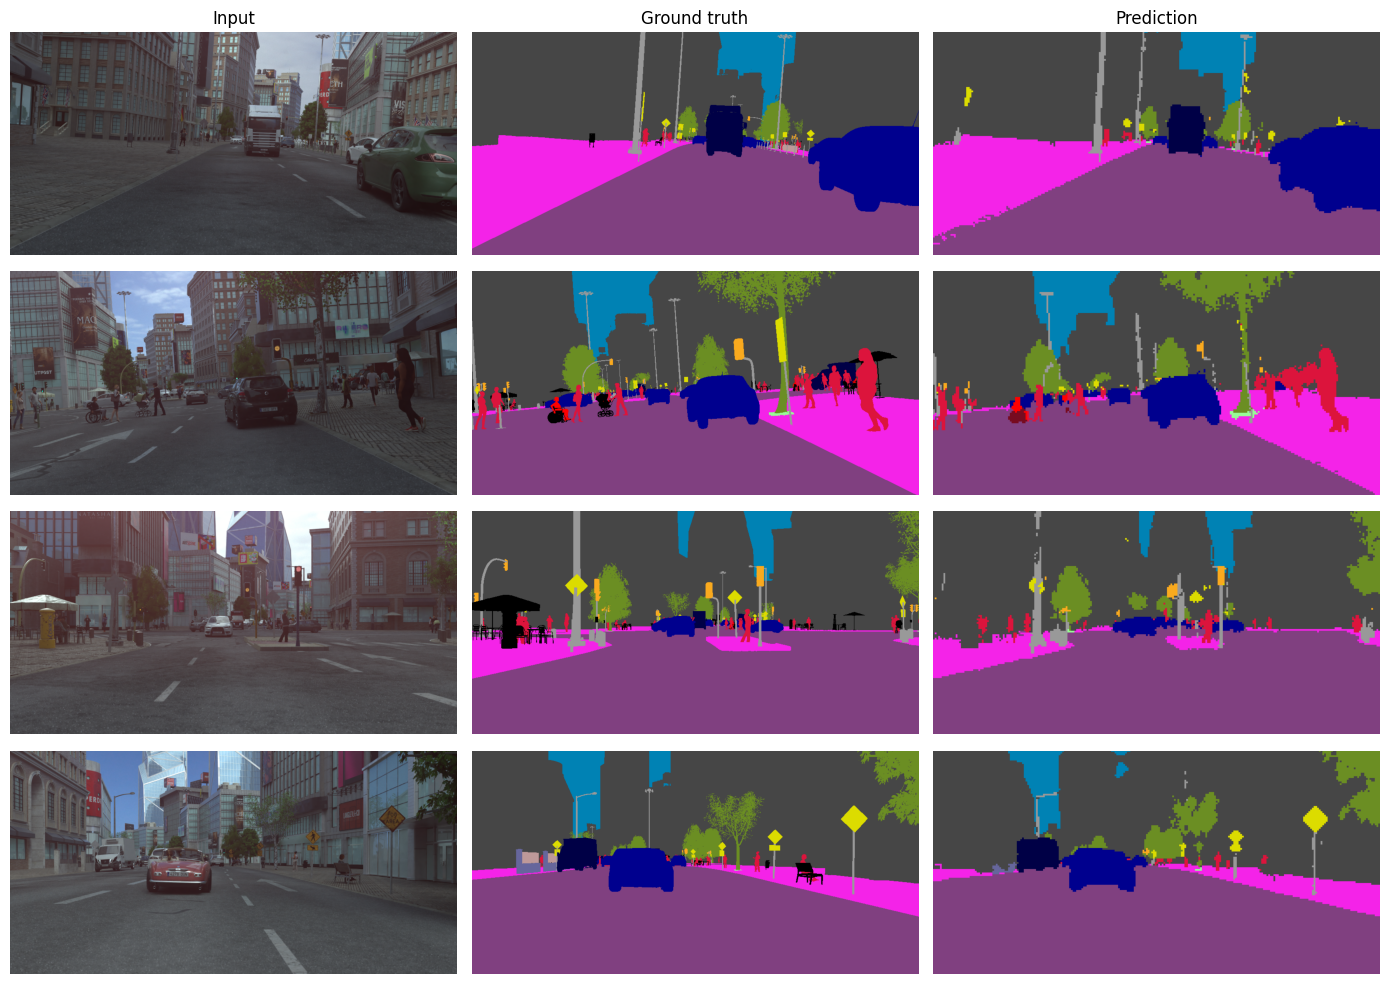

In [20]:
num_images = 4

datamodule = us.get_datamodule(batch_size=num_images, downscaling=2)
datamodule.setup('val')
x, target = next(iter(datamodule.val_dataloader()))

lightning_model.eval()
output = lightning_model(x.to(lightning_model.device)).detach().cpu()

segmaps = urbansyn.colorize_segmap(torch.argmax(output, 1), for_pil=True)
true_segmaps = urbansyn.colorize_segmap(target, for_pil=True)

i = 0
fig,ax = plt.subplots(num_images, 3, figsize=(14,10))
for image, true_segmap, segmap in zip(x, true_segmaps, segmaps):
    ax[i, 0].imshow(rearrange(urbansyn.INV_NORMALIZE(image), 'c h w -> h w c'))
    ax[i, 0].axis('off')
    ax[i, 1].imshow(true_segmap)
    ax[i, 1].axis('off')
    ax[i, 2].imshow(segmap)
    ax[i, 2].axis('off')
    if i==0:
        ax[i, 0].set_title('Input')
        ax[i, 1].set_title('Ground truth')
        ax[i, 2].set_title('Prediction')
    i += 1
plt.tight_layout()
# plt.savefig(os.path.join(root_dir, 'img', 'val_results.png'))
plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

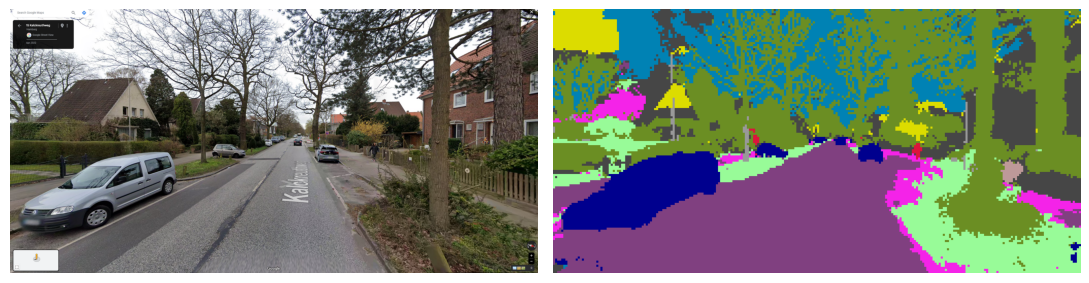

In [26]:
input_path = os.path.join(root_dir, 'data', 'Kalckreuthweg.png')
input = np.array(Image.open(input_path).convert('RGB'))
transform = A.Compose([A.Resize(512, 1024), A.Normalize(), ToTensorV2()])
x = transform(image=input)['image'].unsqueeze(0).unsqueeze(0)

output = trainer.predict(lightning_model, x)[0].detach().cpu()
segmap = urbansyn.colorize_segmap(torch.argmax(output, 1), for_pil=True)[0]

fig,ax = plt.subplots(1, 2, figsize=(11,3))
ax[0].imshow(input)
ax[0].axis('off')
ax[1].imshow(segmap)
ax[1].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(root_dir, 'img', 'kalckreuthweg_results.png'))
plt.show()